In [193]:
import torch

In [392]:
depth = '1'
file_name = 'vit-SLM-single-head-CIFAR100-LR[0.001]-Seed0'

In [393]:
model = torch.load('save/'+file_name+'/best.pth')

In [410]:
mask = model['model_state_dict']['transformer.layers.'+depth+'.0.fn.mask.mask'].cpu()
mask = (mask - mask.mean()) / mask.std()

In [411]:
mask.shape

torch.Size([64, 64])

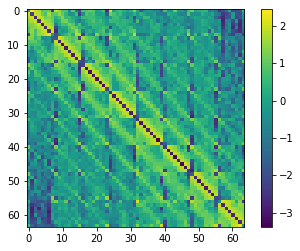

In [413]:
import matplotlib.pyplot as plt
import numpy as np

# for i in range(12):
#     plt.imshow(mask[i])
#     plt.show()

plt.axis('on')
plt.imshow(mask)
plt.colorbar()
plt.savefig('figs/'+file_name+depth+'mask.png')
plt.show()

In [414]:
plt.axis('off')
plt.imshow(mask[0].view(1, 64))
plt.savefig('figs/'+file_name+depth+'mask_1row.png')
plt.show()

In [415]:
mask1 = torch.zeros(64, 64)

In [416]:
mask1[np.arange(64), np.arange(64)] += -5

In [417]:
mask2 = mask - mask1

In [418]:
mask1 = (mask1 - mask1.mean()) / mask1.std()
mask2 = (mask2 - mask1.mean()) / mask2.std()

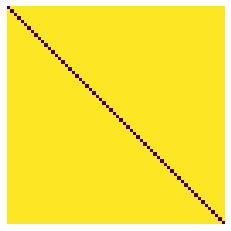

In [423]:
plt.axis('off')
plt.imshow(mask1)
plt.savefig('figs/mask_1.png')
plt.show()

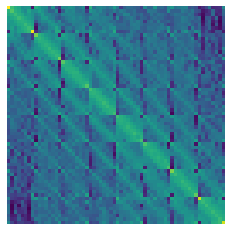

In [424]:
plt.axis('off')
plt.imshow(mask2)
plt.savefig('figs/mask_2.png')
plt.show()

In [366]:
# gmm

In [1]:
import torch
from torch import nn

class Simple_Mask(nn.Module):
    def __init__(self, num_heads, num_patches):
        super(Simple_Mask, self).__init__()
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.mask = nn.Parameter(torch.zeros(num_patches, num_patches))
    
    def forward(self, x):
        return self.mask * x

class Gaussian_Mixture_Mask(nn.Module):
    def __init__(self, num_heads, num_kernals, mask):
        super(Gaussian_Mixture_Mask, self).__init__()
        self.num_kernals = num_kernals
        self.sigma = nn.Parameter(torch.randn(num_kernals, num_heads, 1, 1) * 10 + 10)
        self.alpha = nn.Parameter(torch.randn(num_kernals, num_heads, 1, 1) * 2)
        self.mask = mask

    def forward(self, x):
        attn = torch.sum(self.alpha * self.mask ** (1 / (self.sigma ** 2 + 1e-5)), 0)
        return attn * x
    
def On_attention_gaussian_mask(num_patches):
    mask = torch.zeros(num_patches, num_patches)
    img_size = num_patches ** 0.5
    for i in range(num_patches):
        for j in range(num_patches):
            x_change = i % img_size - j % img_size
            y_change = i // img_size - j // img_size
            mask[i, j] = - (x_change ** 2 + y_change ** 2)
    mask = torch.exp(mask) ** (1 / 2)
    return mask.expand(1, 1, num_patches, num_patches)


In [2]:
depth = '3'

In [3]:
model_dict = torch.load('save/vit-GMM--CIFAR10-LR[0.001]-Seed0/best.pth')

In [280]:
alpha = model_dict['model_state_dict']['transformer.layers.'+depth+'.0.fn.mask.alpha']
sigma = model_dict['model_state_dict']['transformer.layers.'+depth+'.0.fn.mask.sigma']
basic_mask = model_dict['model_state_dict']['mask']

In [43]:
basic_mask = model_dict['model_state_dict']['mask'].cpu()
# alpha = torch.tensor([0.6, -1]).view(2, 1, 1, 1).cpu()
alpha = torch.tensor([-1]).view(1, 1, 1, 1).cpu()
# sigma = torch.tensor([2, 0.2]).view(2, 1, 1, 1).cpu()
sigma = torch.tensor([0.2]).view(1, 1, 1, 1).cpu()

In [44]:
mask = torch.sum(alpha * basic_mask ** (1 / (sigma ** 2 + 1e-5)), 0).cpu()

In [45]:
mask.shape

torch.Size([1, 64, 64])

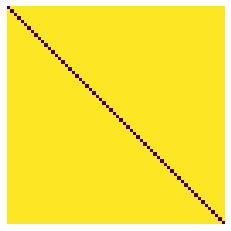

In [47]:
import matplotlib.pyplot as plt

# for i in range(12):
#     plt.imshow(mask[i])
#     plt.show()

plt.axis('off')
plt.imshow(mask[0])
plt.savefig('figs/mask_manual2.png')
plt.show()

In [367]:
# to kernal

In [368]:
mask.shape

torch.Size([64, 64])

In [370]:
kernal = mask.view(64, 8, 8)

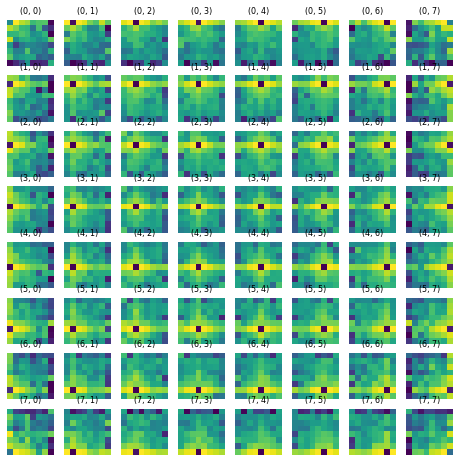

In [387]:
# 用 plt.figure() 生成一个 3 x 3 的子图
plt.figure(figsize=(8,8))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, i*8+j+1)
        plt.imshow(kernal[i*8+j])
        # 加一个标题
        title_str = '(%d, %d)'%(i, j)
        plt.title(title_str, fontsize=8)
        plt.axis('off')
plt.savefig('figs/kernels.png')
plt.show()

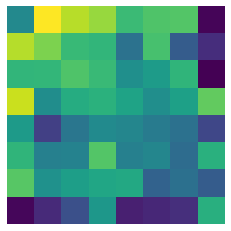

In [385]:
plt.imshow(kernal[0])
plt.axis('off')
plt.savefig('figs/kernels_1row.png')
plt.show()

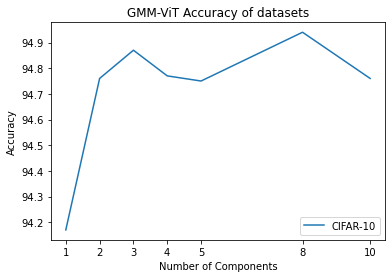

In [2]:
import matplotlib.pyplot as plt

# 创建 % 列表
acc_CIFAR10=[94.17, 94.76, 94.87, 94.77, 94.75, 94.94, 94.76]
acc_CIFAR100=[75.36, 77.20, 76.64, 77.19, 77.81, 77.56, 77.41]
acc_SVHN=[97.93, 97.89, 97.99, 97.90, 98.01, 97.98, 97.89]
acc_TINY=[59.89, 61.74, 62.27, 62.01, 61.86, 61.73, 61.92]

# 创建 x 轴的刻度
x=[1,2,3,4,5,8,10]

# 设置参数
plt.title("GMM-ViT Accuracy of datasets")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")

# 绘制折线图
plt.plot(x,acc_CIFAR10,label="CIFAR-10")
plt.plot(x,acc_CIFAR100,label="CIFAR-100")
plt.plot(x,acc_SVHN,label="SVHN")
plt.plot(x,acc_TINY,label="TINY")

# 设置 x 轴的刻度
plt.xticks(x)

# 把图例添加到图中。 
plt.legend(loc='lower right')

# 展示图片
plt.show()

In [4]:
import glob
import os
from shutil import move
from os import rmdir

target_folder = './tiny-imagenet-200/val/'

val_dict = {}
with open('./dataset/tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
    for line in f.readlines():
        split_line = line.split('\t')
        val_dict[split_line[0]] = split_line[1]
        
paths = glob.glob('./tiny-imagenet-200/val/images/*')
for path in paths:
    file = path.split('/')[-1]
    folder = val_dict[file]
    if not os.path.exists(target_folder + str(folder)):
        os.mkdir(target_folder + str(folder))
        os.mkdir(target_folder + str(folder) + '/images')
       
for path in paths:
    file = path.split('/')[-1]
    folder = val_dict[file]
    dest = target_folder + str(folder) + '/images/' + str(file)
    move(path, dest)
    
rmdir('./tiny-imagenet-200/val/images')

FileNotFoundError: [Errno 2] No such file or directory: './tiny-imagenet-200/val/images'